# Cancer Gene Expression Analysis

This notebook demonstrates how to analyze gene expression data in cancer samples.
We'll cover:
- Data loading and preprocessing
- Quality control
- Differential expression analysis
- Visualization (PCA, heatmaps, volcano plots)
- Gene set enrichment analysis

In [ ]:
# Install required packages (uncomment if needed)
# pip install pandas numpy matplotlib seaborn scikit-learn scipy statsmodels adjustText

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Generate Sample Data

For demonstration, we'll create synthetic gene expression data.
In practice, you would load real data from sources like:
- TCGA (The Cancer Genome Atlas)
- GEO (Gene Expression Omnibus)
- Your own RNA-seq or microarray data

In [2]:
def generate_sample_data(n_genes=1000, n_tumor=30, n_normal=30, n_de_genes=100):
    """
    Generate synthetic gene expression data
    
    Parameters:
    - n_genes: total number of genes
    - n_tumor: number of tumor samples
    - n_normal: number of normal samples
    - n_de_genes: number of differentially expressed genes
    """
    np.random.seed(42)
    
    # Gene names
    gene_names = [f'Gene_{i:04d}' for i in range(n_genes)]
    
    # Sample names
    tumor_samples = [f'Tumor_{i:02d}' for i in range(n_tumor)]
    normal_samples = [f'Normal_{i:02d}' for i in range(n_normal)]
    all_samples = tumor_samples + normal_samples
    
    # Generate baseline expression (log2 scale)
    baseline_expression = np.random.normal(8, 2, size=(n_genes, n_tumor + n_normal))
    
    # Add differential expression to subset of genes
    de_gene_indices = np.random.choice(n_genes, n_de_genes, replace=False)
    
    for idx in de_gene_indices:
        # Random fold change between 1.5 and 3
        fold_change = np.random.uniform(1.5, 3)
        # Randomly up or down regulate
        direction = np.random.choice([-1, 1])
        
        # Apply to tumor samples
        baseline_expression[idx, :n_tumor] += direction * fold_change
    
    # Create DataFrame
    expression_df = pd.DataFrame(
        baseline_expression,
        index=gene_names,
        columns=all_samples
    )
    
    # Create metadata
    metadata = pd.DataFrame({
        'Sample': all_samples,
        'Condition': ['Tumor']*n_tumor + ['Normal']*n_normal,
        'Age': np.random.randint(40, 80, n_tumor + n_normal),
        'Sex': np.random.choice(['M', 'F'], n_tumor + n_normal)
    })
    
    return expression_df, metadata

# Generate data
expression_data, sample_metadata = generate_sample_data()

print(f"Expression data shape: {expression_data.shape}")
print(f"\nFirst few genes and samples:")
print(expression_data.iloc[:5, :5])
print(f"\nSample metadata:")
print(sample_metadata.head())

Expression data shape: (1000, 60)

First few genes and samples:
           Tumor_00  Tumor_01   Tumor_02   Tumor_03  Tumor_04
Gene_0000  8.993428  7.723471   9.295377  11.046060  7.531693
Gene_0001  7.041652  7.628682   5.787330   5.607587  9.625052
Gene_0002  9.582064  6.181225  10.805589   5.196298  9.173714
Gene_0003  9.251335  6.285685   5.858215   8.964945  7.553074
Gene_0004  6.414959  7.770527   9.009975   9.731510  5.599407

Sample metadata:
     Sample Condition  Age Sex
0  Tumor_00     Tumor   43   F
1  Tumor_01     Tumor   51   F
2  Tumor_02     Tumor   65   F
3  Tumor_03     Tumor   45   F
4  Tumor_04     Tumor   49   M


## 2. Data Quality Control

Missing values: 0


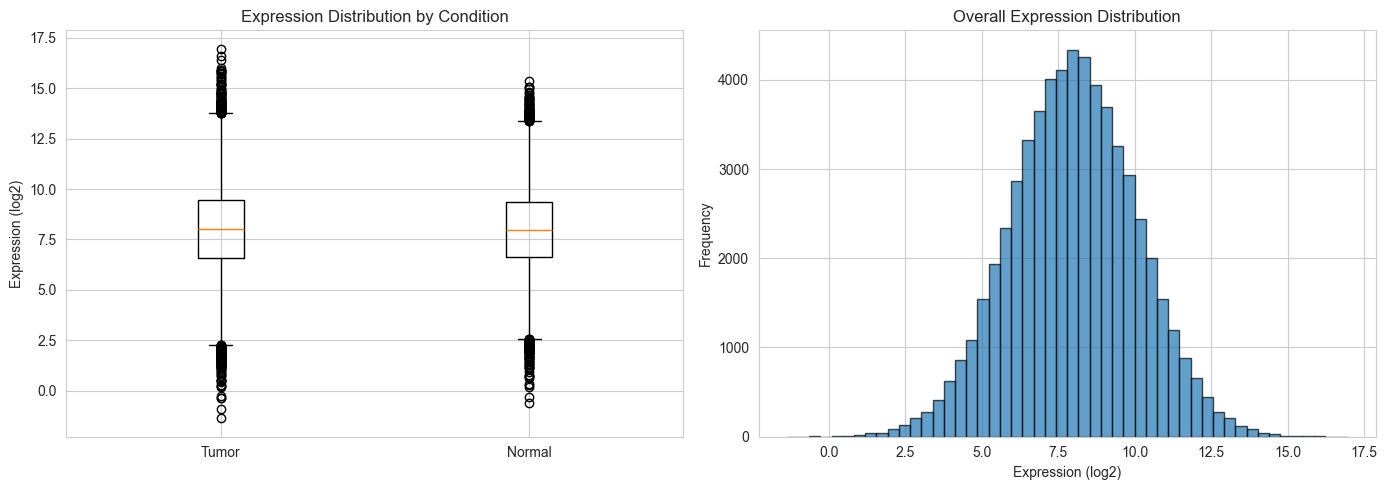


Expression summary statistics:
          Tumor_00     Tumor_01     Tumor_02     Tumor_03     Tumor_04  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      8.065289     7.865263     8.027265     8.027523     8.111313   
std       2.150974     2.111064     2.101783     2.097652     2.078176   
min       0.536944     1.340992     1.657978     1.212171     1.592200   
25%       6.717566     6.553927     6.535673     6.699949     6.677275   
50%       8.067287     7.860793     8.025630     8.051425     8.129292   
75%       9.511105     9.237538     9.492810     9.477751     9.473556   
max      15.204830    14.757680    13.998779    16.958169    15.367365   

          Tumor_05     Tumor_06     Tumor_07     Tumor_08     Tumor_09  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      8.101954     8.098445     7.955780     8.010053     8.052352  ...   
std       2.137492     2.154520     2.109781     2.060217     2.

In [3]:
# Check for missing values
print(f"Missing values: {expression_data.isna().sum().sum()}")

# Distribution of expression values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot of samples
tumor_cols = [col for col in expression_data.columns if 'Tumor' in col]
normal_cols = [col for col in expression_data.columns if 'Normal' in col]

axes[0].boxplot([expression_data[tumor_cols].values.flatten(), 
                 expression_data[normal_cols].values.flatten()],
                labels=['Tumor', 'Normal'])
axes[0].set_ylabel('Expression (log2)')
axes[0].set_title('Expression Distribution by Condition')

# Histogram
axes[1].hist(expression_data.values.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Expression (log2)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Overall Expression Distribution')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nExpression summary statistics:")
print(expression_data.describe())

## 3. Principal Component Analysis (PCA)

PCA helps visualize sample relationships and identify batch effects or outliers.

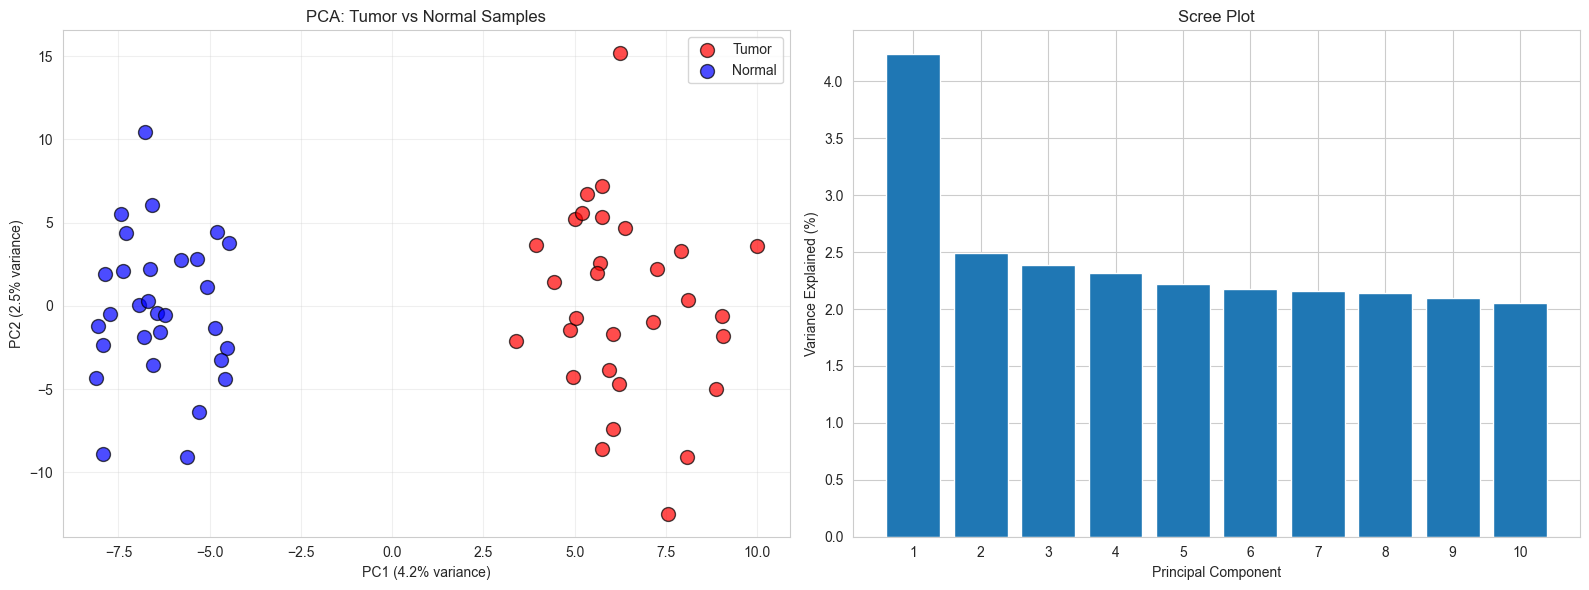


Cumulative variance explained by first 3 PCs: 9.1%


In [4]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(expression_data.T)

# Perform PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(scaled_data)

# Create PCA DataFrame
pca_df = pd.DataFrame(
    pca_result,
    columns=[f'PC{i+1}' for i in range(10)],
    index=expression_data.columns
)
pca_df['Condition'] = sample_metadata['Condition'].values

# Plot PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1 vs PC2
for condition, color in [('Tumor', 'red'), ('Normal', 'blue')]:
    mask = pca_df['Condition'] == condition
    axes[0].scatter(
        pca_df.loc[mask, 'PC1'],
        pca_df.loc[mask, 'PC2'],
        c=color,
        label=condition,
        s=100,
        alpha=0.7,
        edgecolors='black'
    )

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('PCA: Tumor vs Normal Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scree plot
axes[1].bar(range(1, 11), pca.explained_variance_ratio_ * 100)
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained (%)')
axes[1].set_title('Scree Plot')
axes[1].set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

print(f"\nCumulative variance explained by first 3 PCs: {pca.explained_variance_ratio_[:3].sum()*100:.1f}%")

## 4. Differential Expression Analysis

We'll use t-tests to identify genes that are significantly different between tumor and normal samples.

In [5]:
def perform_differential_expression(expression_df, metadata, group_col='Condition', 
                                   group1='Tumor', group2='Normal'):
    """
    Perform differential expression analysis using t-test
    """
    results = []
    
    # Get sample indices for each group
    group1_samples = metadata[metadata[group_col] == group1]['Sample'].values
    group2_samples = metadata[metadata[group_col] == group2]['Sample'].values
    
    for gene in expression_df.index:
        group1_expr = expression_df.loc[gene, group1_samples].values
        group2_expr = expression_df.loc[gene, group2_samples].values
        
        # Calculate statistics
        mean1 = np.mean(group1_expr)
        mean2 = np.mean(group2_expr)
        fold_change = mean1 - mean2  # log2 fold change
        
        # T-test
        t_stat, p_value = stats.ttest_ind(group1_expr, group2_expr)
        
        results.append({
            'Gene': gene,
            'Mean_Tumor': mean1,
            'Mean_Normal': mean2,
            'Log2FC': fold_change,
            'T_statistic': t_stat,
            'P_value': p_value
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple testing correction (FDR)
    _, results_df['FDR'], _, _ = multipletests(
        results_df['P_value'],
        method='fdr_bh'
    )
    
    # Add significance label
    results_df['Significant'] = (results_df['FDR'] < 0.05) & (abs(results_df['Log2FC']) > 1)
    
    # Sort by p-value
    results_df = results_df.sort_values('P_value')
    
    return results_df

# Perform differential expression
de_results = perform_differential_expression(expression_data, sample_metadata)

# Summary
n_significant = de_results['Significant'].sum()
n_upregulated = ((de_results['Significant']) & (de_results['Log2FC'] > 0)).sum()
n_downregulated = ((de_results['Significant']) & (de_results['Log2FC'] < 0)).sum()

print(f"Differential Expression Summary:")
print(f"Total significant genes (FDR < 0.05, |Log2FC| > 1): {n_significant}")
print(f"Upregulated in tumor: {n_upregulated}")
print(f"Downregulated in tumor: {n_downregulated}")
print(f"\nTop 10 differentially expressed genes:")
print(de_results[['Gene', 'Log2FC', 'P_value', 'FDR', 'Significant']].head(10))

Differential Expression Summary:
Total significant genes (FDR < 0.05, |Log2FC| > 1): 90
Upregulated in tumor: 41
Downregulated in tumor: 49

Top 10 differentially expressed genes:
          Gene    Log2FC       P_value           FDR  Significant
506  Gene_0506  3.157314  2.452227e-10  1.351357e-07         True
969  Gene_0969  3.609019  2.702715e-10  1.351357e-07         True
123  Gene_0123  3.478090  9.388430e-10  3.129477e-07         True
497  Gene_0497 -3.810902  1.330313e-09  3.325782e-07         True
85   Gene_0085 -3.154433  7.339285e-09  1.467857e-06         True
73   Gene_0073  3.124246  1.303404e-08  2.172341e-06         True
804  Gene_0804  3.301461  1.531204e-08  2.187434e-06         True
607  Gene_0607  3.246874  2.296739e-08  2.684098e-06         True
917  Gene_0917  3.412635  2.415688e-08  2.684098e-06         True
759  Gene_0759  3.386208  5.957672e-08  5.957672e-06         True


## 5. Volcano Plot

Visualize the relationship between fold change and statistical significance.

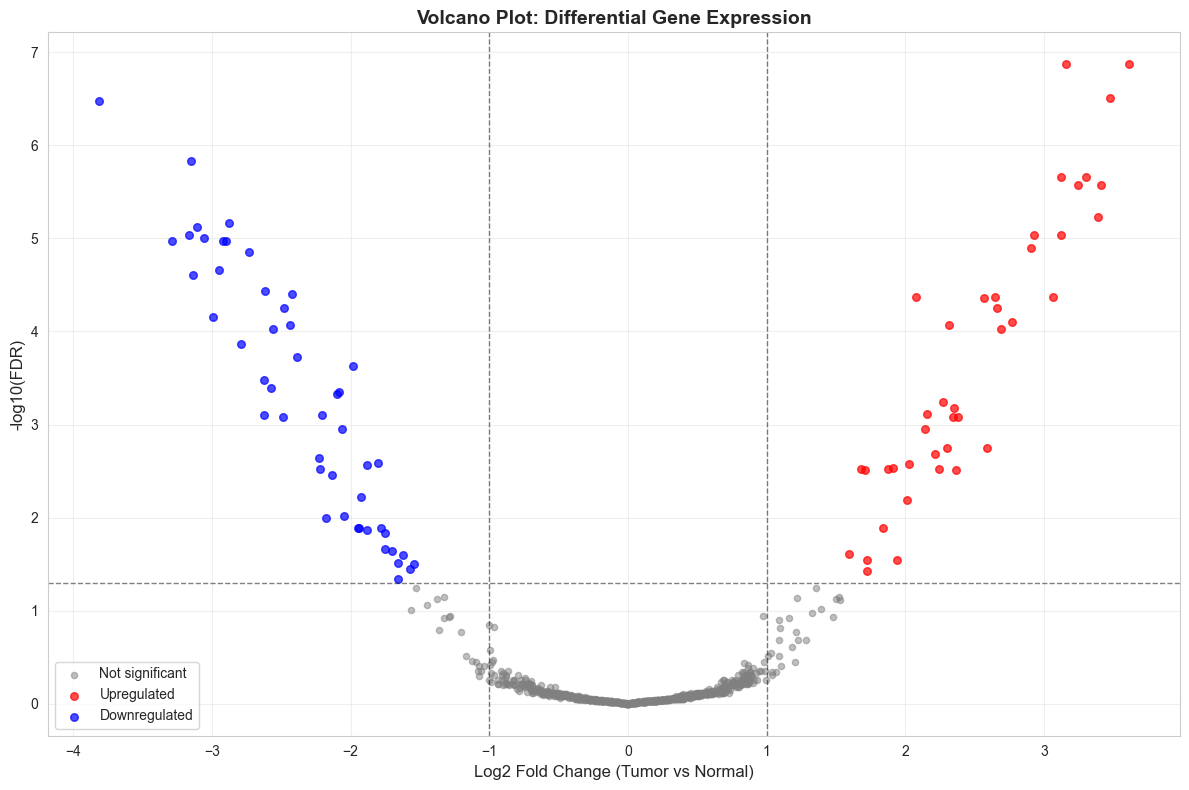

In [6]:
# Prepare data for volcano plot
de_results['-log10(FDR)'] = -np.log10(de_results['FDR'])

# Create volcano plot
plt.figure(figsize=(12, 8))

# Not significant
not_sig = de_results[~de_results['Significant']]
plt.scatter(not_sig['Log2FC'], not_sig['-log10(FDR)'], 
           c='gray', alpha=0.5, s=20, label='Not significant')

# Significant and upregulated
sig_up = de_results[(de_results['Significant']) & (de_results['Log2FC'] > 0)]
plt.scatter(sig_up['Log2FC'], sig_up['-log10(FDR)'], 
           c='red', alpha=0.7, s=30, label='Upregulated')

# Significant and downregulated
sig_down = de_results[(de_results['Significant']) & (de_results['Log2FC'] < 0)]
plt.scatter(sig_down['Log2FC'], sig_down['-log10(FDR)'], 
           c='blue', alpha=0.7, s=30, label='Downregulated')

# Add threshold lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(-1, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Log2 Fold Change (Tumor vs Normal)', fontsize=12)
plt.ylabel('-log10(FDR)', fontsize=12)
plt.title('Volcano Plot: Differential Gene Expression', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Heatmap of Top Differentially Expressed Genes

<Figure size 1400x1000 with 0 Axes>

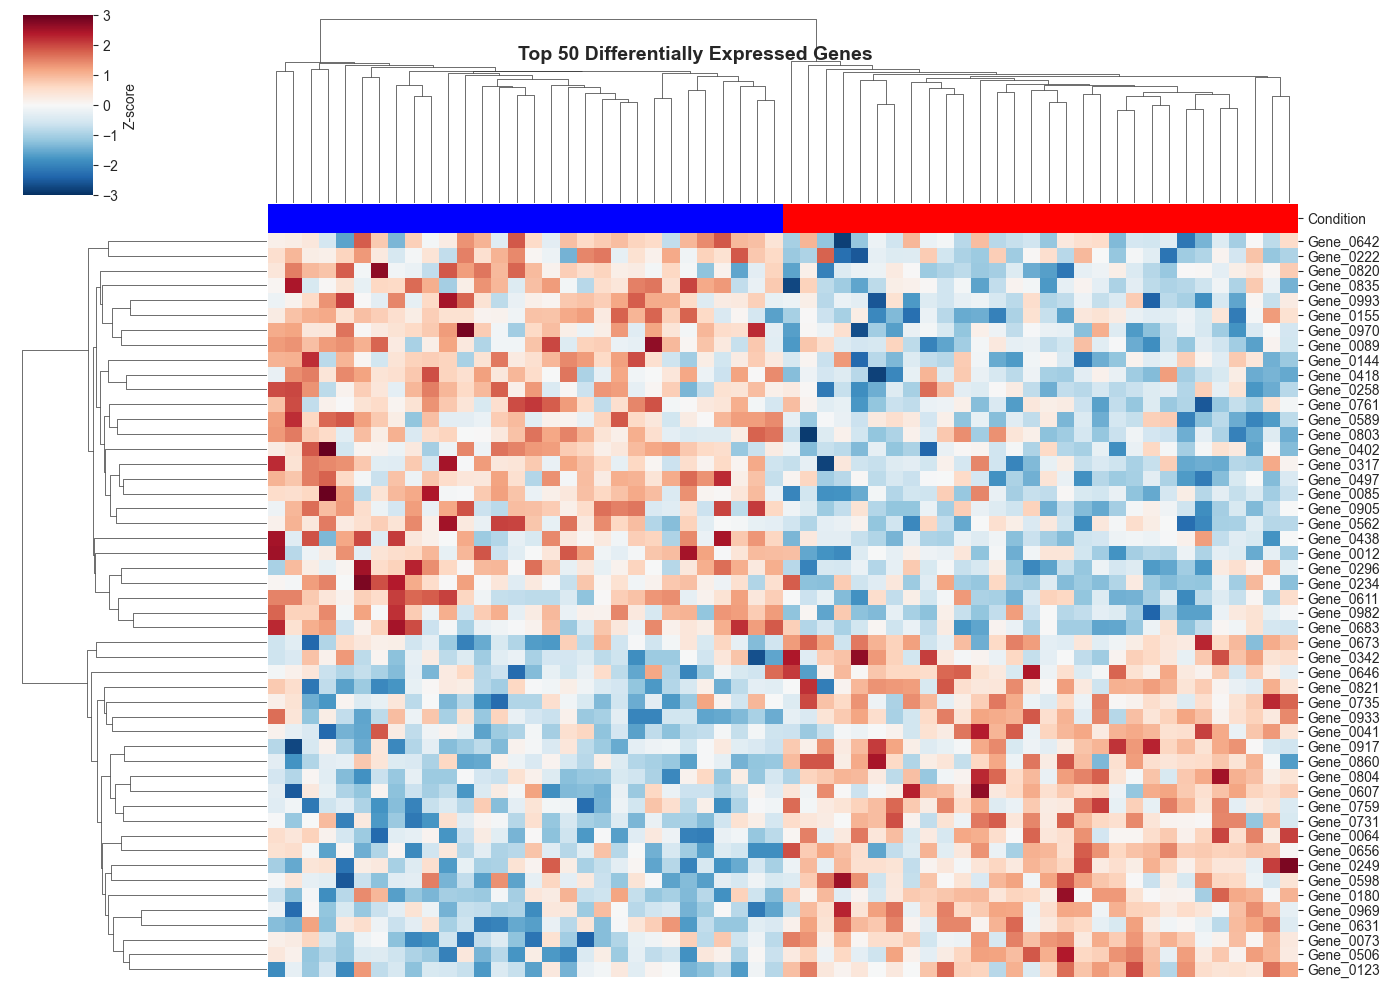

In [7]:
# Select top 50 differentially expressed genes
top_genes = de_results.nsmallest(50, 'FDR')['Gene'].values

# Subset expression data
heatmap_data = expression_data.loc[top_genes]

# Z-score normalize for visualization
heatmap_data_zscore = heatmap_data.sub(heatmap_data.mean(axis=1), axis=0).div(heatmap_data.std(axis=1), axis=0)

# Create color map for conditions
condition_colors = sample_metadata.set_index('Sample')['Condition'].map(
    {'Tumor': 'red', 'Normal': 'blue'}
)

# Create heatmap
plt.figure(figsize=(14, 10))
sns.clustermap(
    heatmap_data_zscore,
    col_colors=condition_colors,
    cmap='RdBu_r',
    center=0,
    vmin=-3,
    vmax=3,
    figsize=(14, 10),
    cbar_kws={'label': 'Z-score'},
    yticklabels=True,
    xticklabels=False
)
plt.suptitle('Top 50 Differentially Expressed Genes', y=0.95, fontsize=14, fontweight='bold')
plt.show()

## 7. Expression Profiles of Top Genes

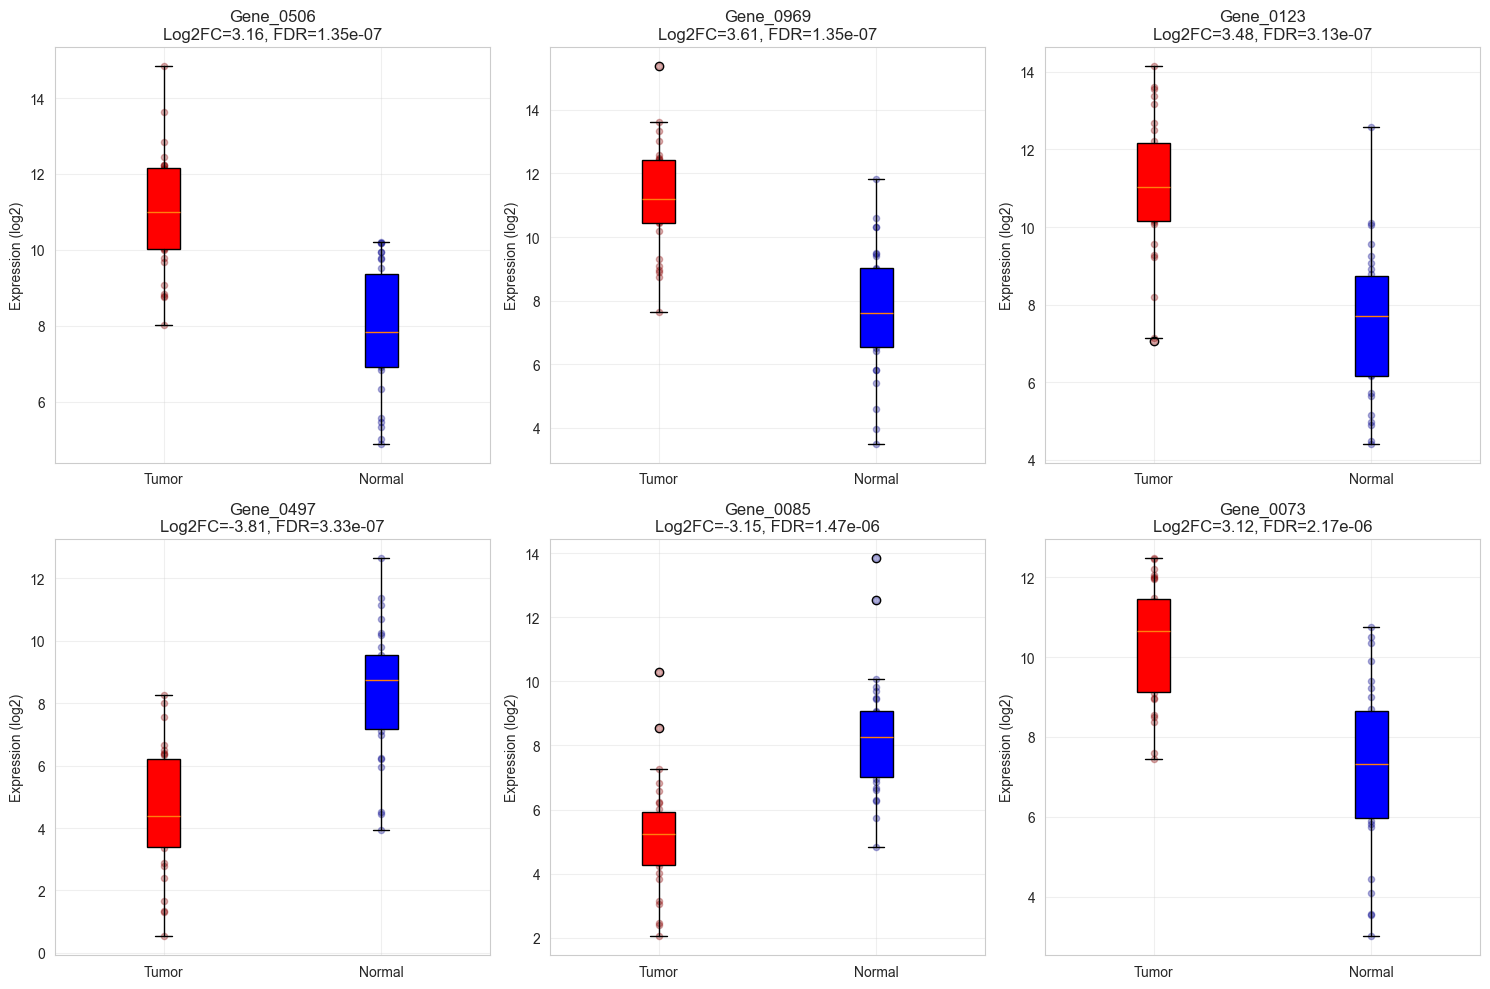

In [8]:
# Plot top 6 genes
top_6_genes = de_results.nsmallest(6, 'FDR')['Gene'].values

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, gene in enumerate(top_6_genes):
    gene_expr = expression_data.loc[gene]
    
    tumor_expr = gene_expr[tumor_cols].values
    normal_expr = gene_expr[normal_cols].values
    
    # Box plot
    box_data = [tumor_expr, normal_expr]
    bp = axes[idx].boxplot(box_data, labels=['Tumor', 'Normal'], patch_artist=True)
    
    # Color boxes
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][1].set_facecolor('blue')
    
    # Add individual points
    axes[idx].scatter([1]*len(tumor_expr), tumor_expr, alpha=0.3, c='darkred', s=20)
    axes[idx].scatter([2]*len(normal_expr), normal_expr, alpha=0.3, c='darkblue', s=20)
    
    # Get stats for this gene
    gene_stats = de_results[de_results['Gene'] == gene].iloc[0]
    
    axes[idx].set_ylabel('Expression (log2)')
    axes[idx].set_title(f"{gene}\nLog2FC={gene_stats['Log2FC']:.2f}, FDR={gene_stats['FDR']:.2e}")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Results

In [9]:
# Save differential expression results
de_results.to_csv('differential_expression_results.csv', index=False)
print("Saved: differential_expression_results.csv")

# Save significant genes only
significant_genes = de_results[de_results['Significant']]
significant_genes.to_csv('significant_genes.csv', index=False)
print(f"Saved: significant_genes.csv ({len(significant_genes)} genes)")

# Save expression data for top genes
top_100_genes = de_results.nsmallest(100, 'FDR')['Gene'].values
expression_data.loc[top_100_genes].to_csv('top100_gene_expression.csv')
print("Saved: top100_gene_expression.csv")

Saved: differential_expression_results.csv
Saved: significant_genes.csv (90 genes)
Saved: top100_gene_expression.csv


## 9. Optional: Gene Set Analysis

For real data, you might want to perform pathway enrichment analysis using tools like:
- GSEA (Gene Set Enrichment Analysis)
- GO (Gene Ontology) enrichment
- KEGG pathway analysis

Python packages for this include:
- `gseapy`
- `enrichr`
- `goatools`

In [10]:
# Example: Create a ranked gene list for GSEA
# Rank genes by -log10(p-value) * sign(log2FC)
de_results['Rank_Metric'] = -np.log10(de_results['P_value']) * np.sign(de_results['Log2FC'])
ranked_genes = de_results[['Gene', 'Rank_Metric']].sort_values('Rank_Metric', ascending=False)

print("\nTop 10 genes by ranking metric:")
print(ranked_genes.head(10))

# Save ranked list for external tools
ranked_genes.to_csv('ranked_gene_list.csv', index=False)
print("\nSaved: ranked_gene_list.csv (for use with GSEA or other tools)")


Top 10 genes by ranking metric:
          Gene  Rank_Metric
506  Gene_0506     9.610439
969  Gene_0969     9.568200
123  Gene_0123     9.027407
73   Gene_0073     7.884921
804  Gene_0804     7.814967
607  Gene_0607     7.638888
917  Gene_0917     7.616959
759  Gene_0759     7.224923
64   Gene_0064     6.905465
731  Gene_0731     6.861137

Saved: ranked_gene_list.csv (for use with GSEA or other tools)


## Summary

This notebook demonstrated:
1. Loading and quality control of gene expression data
2. PCA for sample visualization
3. Differential expression analysis with statistical testing
4. Multiple testing correction (FDR)
5. Visualization with volcano plots and heatmaps
6. Export of results for further analysis

### Next Steps for Real Data:
- Load data from TCGA, GEO, or your own experiments
- Perform batch effect correction if needed
- Use more sophisticated methods (DESeq2, edgeR for RNA-seq)
- Perform pathway enrichment analysis
- Validate findings with independent datasets
- Integrate with clinical data for survival analysis